In [6]:
#!/usr/bin/env python3
import random, collections, heapq, math

# ───────── PARAMETERS ─────────
WALK_SPEED     = 1.4
CAP_CORRIDOR   = 20
CAP_STAIR      = 10
CAP_EXIT       = 40
CAP_OTHER      = 15
POP_SIZE       = 40
GENERATIONS    = 30
F, CR          = 0.9, 0.8

# ───────── BUILDING GEOMETRY ─────────
NODES = {
    # Floor 1
    "F1R1":{"type":"Room","occupants":15}, "F1R2":{"type":"Room","occupants":10},
    "F1R3":{"type":"Room","occupants":12}, "F1R4":{"type":"Room","occupants":8},
    "F1R5":{"type":"Room","occupants":22}, "F1R6":{"type":"Room","occupants":20},
    "F1C1":{"type":"Corridor","occupants":0}, "F1C2":{"type":"Corridor","occupants":0},
    "S1F1":{"type":"Stair","occupants":0},   "S2F1":{"type":"Stair","occupants":0},
    "E1":  {"type":"Exit","occupants":0},     "E2":  {"type":"Exit","occupants":0},
    "E3":  {"type":"Exit","occupants":0},
    # Floor 2
    "F2R1":{"type":"Room","occupants":14}, "F2R2":{"type":"Room","occupants":16},
    "F2R3":{"type":"Room","occupants":18}, "F2R4":{"type":"Room","occupants":10},
    "F2R5":{"type":"Room","occupants":12}, "F2R6":{"type":"Room","occupants":25},
    "F2C1":{"type":"Corridor","occupants":0}, "F2C2":{"type":"Corridor","occupants":0},
    "S1F2":{"type":"Stair","occupants":0},  "S2F2":{"type":"Stair","occupants":0},
    # Floor 3
    "F3R1":{"type":"Room","occupants":20}, "F3R2":{"type":"Room","occupants":15},
    "F3R3":{"type":"Room","occupants":12}, "F3R4":{"type":"Room","occupants":18},
    "F3R5":{"type":"Room","occupants":16}, "F3R6":{"type":"Room","occupants":14},
    "F3C1":{"type":"Corridor","occupants":0}, "F3C2":{"type":"Corridor","occupants":0},
    "S1F3":{"type":"Stair","occupants":0},  "S2F3":{"type":"Stair","occupants":0},
    # Floor 4
    "F4R1":{"type":"Room","occupants":12}, "F4R2":{"type":"Room","occupants":8},
    "F4R3":{"type":"Room","occupants":10}, "F4R4":{"type":"Room","occupants":25},
    "F4R5":{"type":"Room","occupants":22}, "F4R6":{"type":"Room","occupants":15},
    "F4C1":{"type":"Corridor","occupants":0}, "F4C2":{"type":"Corridor","occupants":0},
    "S1F4":{"type":"Stair","occupants":0},  "S2F4":{"type":"Stair","occupants":0},
    # Floor 5
    "F5R1":{"type":"Room","occupants":15}, "F5R2":{"type":"Room","occupants":20},
    "F5R3":{"type":"Room","occupants":18}, "F5R4":{"type":"Room","occupants":16},
    "F5R5":{"type":"Room","occupants":10}, "F5R6":{"type":"Room","occupants":12},
    "F5C1":{"type":"Corridor","occupants":0}, "F5C2":{"type":"Corridor","occupants":0},
    "S1F5":{"type":"Stair","occupants":0},  "S2F5":{"type":"Stair","occupants":0},
}

EDGES = [
    # (u, v, dist[m], risk, cap_override)
    ("F1R1","F1C1",5,0.20,None),  ("F1R2","F1C1",5,0.20,None),
    ("F1R3","F1C2",6,0.30,None),  ("F1R4","F1C2",5,0.20,None),
    ("F1R5","F1C1",8,0.40,None),  ("F1R6","F1C2",8,0.40,None),
    ("F1C1","F1C2",3,0.20,None),
    ("F1C1","S1F1",4,0.20,None),  ("F1C2","S2F1",4,0.20,None),
    ("S1F1","E1",  5,0.10,None),  ("S2F1","E2",  5,0.10,None),
    ("F1C2","E3",  6,0.10,None),
    # Floor 2
    ("F2R1","F2C1",5,0.20,None),  ("F2R2","F2C1",6,0.30,None),
    ("F2R3","F2C2",6,0.30,None),  ("F2R4","F2C2",5,0.20,None),
    ("F2R5","F2C1",7,0.40,None),  ("F2R6","F2C2",8,0.50,None),
    ("F2C1","F2C2",3,0.20,None),
    ("F2C1","S1F2",4,0.20,None),  ("F2C2","S2F2",4,0.20,None),
    # Floor 3
    ("F3R1","F3C1",5,0.20,None),  ("F3R2","F3C1",5,0.30,None),
    ("F3R3","F3C2",6,0.30,None),  ("F3R4","F3C2",5,0.20,None),
    ("F3R5","F3C1",7,0.40,None),  ("F3R6","F3C2",8,0.50,None),
    ("F3C1","F3C2",3,0.20,None),
    ("F3C1","S1F3",4,0.20,None),  ("F3C2","S2F3",4,0.20,None),
    # Floor 4
    ("F4R1","F4C1",5,0.30,None),  ("F4R2","F4C1",6,0.40,None),
    ("F4R3","F4C2",6,0.40,None),  ("F4R4","F4C2",5,0.30,None),
    ("F4R5","F4C1",8,0.50,None),  ("F4R6","F4C2",7,0.50,None),
    ("F4C1","F4C2",3,0.30,None),
    ("F4C1","S1F4",4,0.30,None),  ("F4C2","S2F4",4,0.30,None),
    # Floor 5
    ("F5R1","F5C1",5,0.30,None),  ("F5R2","F5C1",6,0.40,None),
    ("F5R3","F5C2",6,0.50,None),  ("F5R4","F5C2",5,0.40,None),
    ("F5R5","F5C1",8,0.60,None),  ("F5R6","F5C2",7,0.50,None),
    ("F5C1","F5C2",3,0.30,None),
    ("F5C1","S1F5",4,0.30,None),  ("F5C2","S2F5",4,0.30,None),
    # inter‐floor stairs
    ("S1F1","S1F2",8,0.20,None),  ("S1F2","S1F3",8,0.20,None),
    ("S1F3","S1F4",8,0.30,None),  ("S1F4","S1F5",8,0.30,None),
    ("S2F1","S2F2",8,0.20,None),  ("S2F2","S2F3",8,0.20,None),
    ("S2F3","S2F4",8,0.30,None),  ("S2F4","S2F5",8,0.30,None),
]

# ───────── GRAPH PREP ─────────
def _cap(n):
    t = NODES[n]["type"]
    return {"Room":CAP_OTHER,"Corridor":CAP_CORRIDOR,
            "Stair":CAP_STAIR,"Exit":CAP_EXIT}[t]

graph, EDGE_DATA = collections.defaultdict(list), {}
for u,v,d,r,c in EDGES:
    capv = c if c is not None else min(_cap(u),_cap(v))
    EDGE_DATA[(u,v)] = EDGE_DATA[(v,u)] = {"dist":d,"risk":r,"cap":capv}
    graph[u].append(v); graph[v].append(u)

ROOMS = [n for n,a in NODES.items() if a["type"]=="Room"]
EXITS = [n for n,a in NODES.items() if a["type"]=="Exit"]
NUM_ROOMS, NUM_EXITS = len(ROOMS), len(EXITS)

# ───────── PRECOMPUTE PATHS ─────────
def dijkstra(src):
    dist, prev = {src:0.0},{src:None}
    pq = [(0.0,src)]
    while pq:
        D,u = heapq.heappop(pq)
        if D>dist[u]: continue
        for w in graph[u]:
            nd = D + EDGE_DATA[(u,w)]["dist"]
            if nd < dist.get(w,1e18):
                dist[w], prev[w] = nd, u
                heapq.heappush(pq,(nd,w))
    return dist, prev

PATH_EDGES = {}
for rm in ROOMS:
    dist, pr = dijkstra(rm)
    for ex in EXITS:
        if ex in dist:
            path,cur = [], ex
            while cur:
                path.append(cur); cur = pr[cur]
            rev = path[::-1]
            PATH_EDGES[(rm,ex)] = list(zip(rev[:-1],rev[1:]))
        else:
            PATH_EDGES[(rm,ex)] = []

# ───────── COST FUNCTION ─────────
def chrom_cost(ch):
    load = collections.Counter()
    for g,rm in zip(ch,ROOMS):
        p = NODES[rm]["occupants"]
        for e in PATH_EDGES[(rm,EXITS[g])]:
            load[e] += p
    T=C=H=0.0
    for g,rm in zip(ch,ROOMS):
        p = NODES[rm]["occupants"]
        for e in PATH_EDGES[(rm,EXITS[g])]:
            d = EDGE_DATA[e]["dist"]; r = EDGE_DATA[e]["risk"]; c = EDGE_DATA[e]["cap"]
            T += (d/WALK_SPEED)*p
            C += (load[e]/c)*p
            H += (r + d)*p
    return (T,C,H)

# ───────── HELPERS ─────────
random_chrom = lambda: [random.randrange(NUM_EXITS) for _ in ROOMS]

def greedy_chrom():
    sol=[]
    for rm in ROOMS:
        best = min(range(NUM_EXITS),
                   key=lambda e: sum(EDGE_DATA[f]["dist"]+EDGE_DATA[f]["risk"]
                                    for f in PATH_EDGES[(rm,EXITS[e])]))
        sol.append(best)
    return sol

def dominates(a,b):
    return all(x<=y for x,y in zip(a,b)) and any(x<y for x,y in zip(a,b))

def non_dominated_sort(pop):
    S=[set() for _ in pop]; n=[0]*len(pop); fronts=[[]]
    for i,(_,oi) in enumerate(pop):
        for j,(_,oj) in enumerate(pop):
            if dominates(oi,oj):   S[i].add(j)
            elif dominates(oj,oi): n[i]+=1
        if n[i]==0: fronts[0].append(i)
    k=0
    while fronts[k]:
        nxt=[]
        for i in fronts[k]:
            for j in S[i]:
                n[j]-=1
                if n[j]==0: nxt.append(j)
        k+=1; fronts.append(nxt)
    fronts.pop(); return fronts

def hypervolume(front_objs, ref):
    return sum((ref[0]-t)*(ref[1]-c)*(ref[2]-h)
               for t,c,h in front_objs
               if t<ref[0] and c<ref[1] and h<ref[2])

# ───────── MODE SOLVER ─────────
def solver_mode(seed):
    random.seed(seed)
    # — Greedy seed injection —
    SEED = greedy_chrom()
    pop = [[SEED[:], chrom_cost(SEED)], [SEED[:], chrom_cost(SEED)]]
    while len(pop)<POP_SIZE:
        c = random_chrom()
        pop.append([c, chrom_cost(c)])

    history = []
    for gen in range(GENERATIONS):
        # DE/best/1 variation
        best = min(pop, key=lambda x:x[1])[0]
        offs = []
        for i in range(POP_SIZE):
            a = random.randrange(POP_SIZE)
            mutant = [
                max(0, min(NUM_EXITS-1,
                    int(round(pop[a][0][j] + F*(best[j]-pop[a][0][j])))))
                for j in range(NUM_ROOMS)
            ]
            child = [
                mutant[j] if random.random()<CR else pop[i][0][j]
                for j in range(NUM_ROOMS)
            ]
            offs.append([child, chrom_cost(child)])

        combined = pop + offs
        fronts   = non_dominated_sort(combined)
        history.append((combined, fronts))

        # — Hypervolume-based truncation —
        all_objs = [ind[1] for ind in combined]
        ref_pt   = [max(o[i] for o in all_objs)*1.1 for i in range(3)]
        newpop   = []
        for fr in fronts:
            if len(newpop)+len(fr) <= POP_SIZE:
                newpop += [combined[i] for i in fr]
            else:
                cand = [combined[i] for i in fr]
                base = hypervolume([x[1] for x in newpop+cand], ref_pt)
                contrib = [
                    base - hypervolume(
                        [x[1] for x in newpop+cand if x is not c],
                        ref_pt
                    )
                    for c in cand
                ]
                K = POP_SIZE - len(newpop)
                newpop += [c for c,_ in sorted(
                    zip(cand, contrib), key=lambda x:-x[1]
                )][:K]
                break

        # — Tiny 3-swap hill-climb —
        for indiv in newpop:
            for _ in range(3):
                i,j = random.sample(range(NUM_ROOMS),2)
                trial = indiv[0][:]
                trial[i], trial[j] = trial[j], trial[i]
                c2 = chrom_cost(trial)
                if dominates(c2, indiv[1]):
                    indiv[0], indiv[1] = trial, c2

        pop = newpop

    return history

# ───────── USAGE EXAMPLE ─────────
if __name__=="__main__":
    history = solver_mode(seed=0)
    print(f"Generated history for {GENERATIONS} generations, "
          f"recording 80 candidates each time.")


Generated history for 30 generations, recording 80 candidates each time.


/tmp/ipython-input-7-2731071171.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10').colors


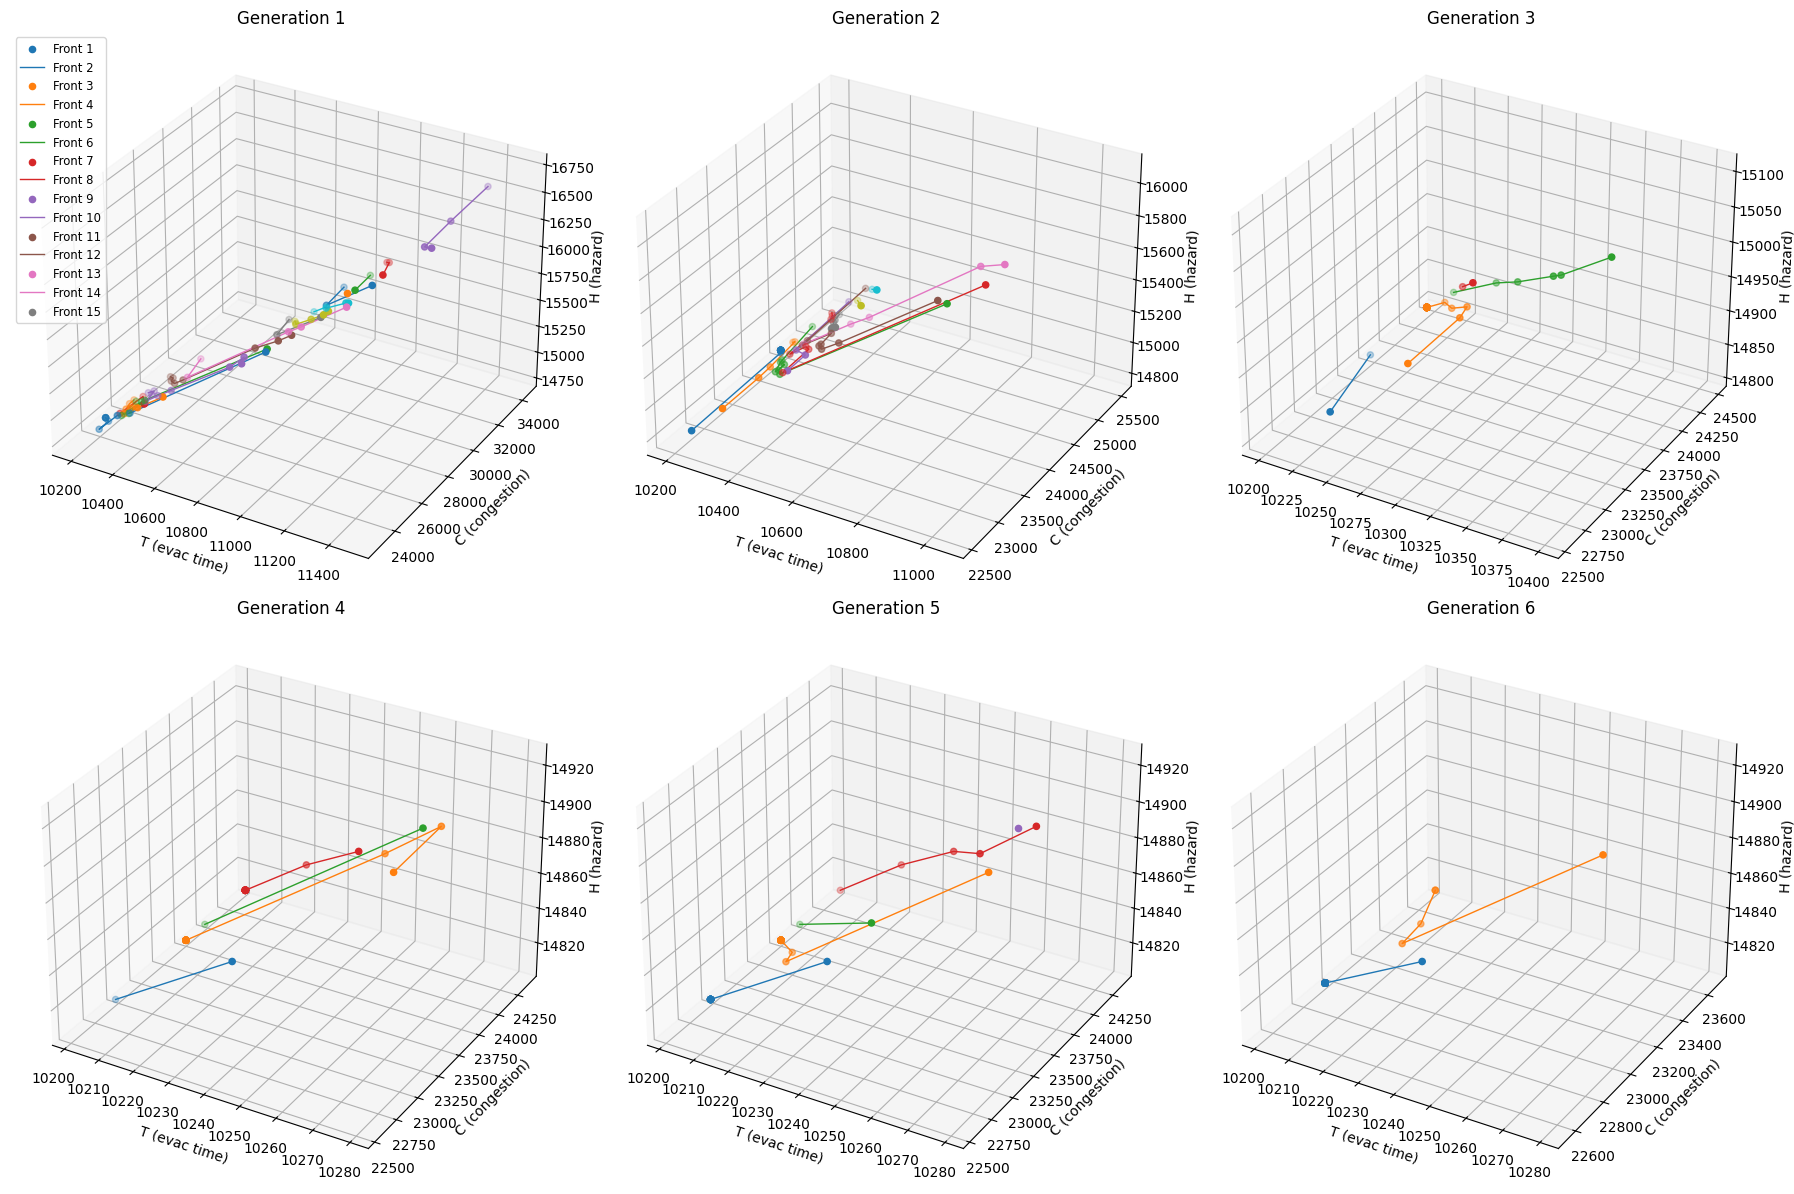

In [7]:
import matplotlib.pyplot as plt

gens_to_plot = [1,2,3,4,5,6]
colors = plt.cm.get_cmap('tab10').colors

fig = plt.figure(figsize=(18, 12))
for idx, gen in enumerate(gens_to_plot):
    pop, fronts = history[gen-1]
    ax = fig.add_subplot(2, 3, idx+1, projection='3d')
    for fi, front in enumerate(fronts):
        pts = [pop[i][1] for i in front]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        zs = [p[2] for p in pts]
        ax.scatter(xs, ys, zs, color=colors[fi % len(colors)], s=20)
        # connect in T‐order for readability
        if len(pts) > 1:
            pts_sorted = sorted(pts, key=lambda q: q[0])
            xs2, ys2, zs2 = zip(*pts_sorted)
            ax.plot(xs2, ys2, zs2, color=colors[fi % len(colors)], lw=1)

    ax.set_title(f'Generation {gen}')
    ax.set_xlabel('T (evac time)')
    ax.set_ylabel('C (congestion)')
    ax.set_zlabel('H (hazard)')
    if idx == 0:
        ax.legend([f'Front {i+1}' for i in range(len(fronts))],
                  loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()
